Final prototype implementation

In [1]:
# import all necessary libraries

from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
import json
from langchain_core.tools import tool
import feedparser
from langgraph.prebuilt import ToolNode
from urllib.parse import quote
import re
from langchain_community.vectorstores import FAISS
from langchain.docstore.document import Document
import numpy as np

Initialize the LLM and embeddings model for retrieval

In [317]:
load_dotenv()

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

# initialize an embedding model
embeddings = GoogleGenerativeAIEmbeddings(model="text-embedding-004")

Initialize the AgentState

In [318]:
# we need states for:
# user query
# plan generated by the LLM 
# results obtained by each search tool
# reflection
# summary
class AgentState(TypedDict):
    query: str # The user query
    original_plan: Dict[str, str] # Entire plan returned by the planner, with rationale and reflection
    plan: List[Dict] # List of plan dicts with tool name, search parameters and reasoning
    results: Dict[str, List] # Result of each search tool
    reflection: bool | None # To determine whether the findings are enough to summarize
    reflection_notes: str # LLM's reasoning notes for the reflection
    summary: str # Final summary
    relevant_docs: List[str]

Now we create the Planner node.

The Planner node:
* First checks if there is any reflection already present in the state, if so, generates a new plan
* Will have a system prompt and a user query from the state. 
* Makes the LLM return a structured JSON object with the detailed execution plan.
* Parse that JSON and update the state variables accordingly.

In [319]:
# System prompt for first time plan

system_prompt = """
You are an expert research agent planner.

You have access to the following tools:
- arxiv_search: for academic papers

Your job is to take a user query and return a structured execution plan in STRICT JSON format.
Do not include any text outside of the JSON. Do not explain your reasoning in prose.

The JSON must follow this schema exactly:

{
"plan": [
    {
    "tool": "<tool_name>",
    "purpose": "<why this step is included>",
    "query": {
        "search_terms": ["<list of exact search terms>"],
        "additional_focus": ["<list of optional focus keywords>"]
    },
    "rationale": "<why these parameters were chosen>"
    }
],
"reflection": {
    "purpose": "<why reflection is needed>",
    "analysis_focus": ["<list of aspects to check>"],
    "rationale": "<why this reflection matters>"
}
}

Return ONLY VALID JSON. Do not include markdown formatting (NO ```json ... ```), explanations, or extra text.
"""

# response = llm.invoke(system_prompt + "\nGenerate a report on evolution of LLMs")

In [320]:
system_prompt_reflection = """
You are an expert research agent planner.

Given the original plan you generated and the reflections from the result of following that plan,
We determined that the original plan did not yield the desired results.
Given the notes from the reflection and original plan, generate a new plan in STRICT JSON format.
Do not include any text outside of the JSON. Do not explain your reasoning in prose.

You have access to the following tools:
- arxiv_search: for academic papers

The JSON must follow this schema exactly:

{
"plan": [
    {
    "tool": "<tool_name>",
    "purpose": "<why this step is included>",
    "query": {
        "search_terms": ["<list of exact search terms>"],
        "additional_focus": ["<list of optional focus keywords>"]
    },
    "rationale": "<why these parameters were chosen>"
    }
],
"reflection": {
    "purpose": "<why reflection is needed>",
    "analysis_focus": ["<list of aspects to check>"],
    "rationale": "<why this reflection matters>"
}
}

Return ONLY VALID JSON. Do not include markdown formatting (NO ```json ... ```), explanations, or extra text.

"""

In [321]:
def planner(state: AgentState) -> AgentState:
    """ Generate a detailed execution plan for the user query """

    print(f"State:\n{state}\n")

    # complete message to pass to the LLM
    message = ""

    # First check if there are any previous reflections in reflection_notes
    # If yes, generate a new plan/ or additional search parameters

    if state["reflection_notes"] != "":
        print(">> GENERATING NEW PLAN...")
        message = system_prompt_reflection + f"\nUser query:\n{state["query"]}\nOriginal plan:\n{json.dumps(state["original_plan"])}\nReflection notes:\n{state["reflection_notes"]}"
    else:
        # If no, this is the first run, run normally
        print(">> GENERATING INITIAL PLAN...")
        message = system_prompt + f"\nUser query:\n{state["query"]}"

    response_json = llm.invoke(message).content
    if response_json.startswith("```json"):
        response_json = response_json[7:-3]
    
    try:
        response_dict = json.loads(response_json)
        state["original_plan"] = response_dict # Load plan JSON as python dictionary
        state["plan"] = response_dict["plan"]

        print(f"PLAN GENERATED, total {len(state["plan"])} queries to be searched:")
        print(state["plan"])

        return {
            **state,
            "original_plan": response_dict,
            "plan": response_dict["plan"]
        }
    
    except Exception as e:
        print(response_json)
        print(e)


The planner node is now ready, let's start defining our tool nodes.

For now, I am only including an arxiv search, will add web search, google scholar search etc. later on

In [322]:
query_expansion_prompt = f"""
    You are an expert at constructing arxiv API queries. 
    Given the following search terms and additional focus terms, generate efficient arXiv API queries.
    Do not generate overly complex queries, as arxiv sometimes does not return results if queries are too complex.

    Requirements:
    - Always include the exact search_terms verbatim.
    - Incorporate additional_focus terms.
    - Use arXiv field prefixes where appropriate:
      - ti: for title
      - abs: for abstract
      - cat:cs.CL for computational linguistics
    - Combine terms with AND/OR for precision.
    - Return 2-3 queries max.

    Return only a JSON list of objects. 
    Each object must have:
    - "search_query": a valid arXiv API query string
    - "max_results": an integer (default 5)

    Return only valid JSON. Do not include markdown formatting, explanations, or extra text.
    """

In [323]:
def search_arxiv(state: AgentState) -> AgentState:
    """ given the current Agent State, search arxiv and return appropriate papers. """

    print("\n>> SEARCHING ARXIV ...")
    # pass the search_terms and additional_terms to the llm
    search_terms = state["plan"][0]["query"]["search_terms"]
    additional_focus = state["plan"][0]["query"]["additional_focus"]

    # make the llm generate appropriate arxiv search queries
    message = query_expansion_prompt + f"\nSearch terms:{search_terms}\nAdditional focus:{additional_focus}"

    queries_json = llm.invoke(message).content
    if queries_json.startswith("```json"):
        queries_json = queries_json[7:-3]

    try:
      queries_dict = json.loads(queries_json)

      # use those queries to search the web for top results

      base_url = 'http://export.arxiv.org/api/query?'
      results = []
      max_results = 5

      # construct valid arxiv url for each search query returned by the LLM and get appropriate papers
      for query in queries_dict:
          search_query = quote(query["search_query"])  # URL-encode
          url = base_url + f"search_query={search_query}&max_results={max_results}&sortBy=submittedDate&sortOrder=descending"
          print(f"url: {url}")
          feed = feedparser.parse(url)
          results.append(feed.entries)

      # for now, store all results just as a list
      # will use a vector store later

      for i in range(len(results)):
        for result in results[i]:
            result_dict = {
              "title": result['title'],
              "published": result['published'],
              "summary": result['summary'],
              "arxiv_link": result['link']
            }
            # not storing for now, will store later
            # "pdf_link": result['links'][2]['href'] # or just /pdf instead of /obs in the arxiv link

            state["results"]["arxiv"].append(result_dict)

      # finally, pop the current tool from plan (pop(0))
      state["plan"].pop(0)
      print(f">> {len(state["plan"])} SEARCHES LEFT...")
      
      return {**state}
    
    except Exception as e:
      print(queries_json)
      print(e)
    

Now, we have defined the planner and tool. Let's add the router node that will check if any tools are yet to be called and routes actions accordingly

In [324]:
def router(state: AgentState) -> str:
    """ To check if any more tool calls are left and routing to the appropriate tools """

    # if plan is empty, go to the reflection step
    if len(state["plan"]) == 0:
        return "relevance"
    else:
        return "tool call"

Between the router/ tool call and reflection, add a retrieval step.

In this step, instead of passing all retrieved papers to the LLM, blowing it's context limits, we retrieve top-k papers similar to the user query and analysis focus generated in the plan

In [325]:
def retrieve(state: AgentState) -> AgentState:
    """ retrieve the top relevant papers from all papers retrieved from arxiv search """

    print("\n>> RETRIEVING RELEVANT PAPERS...")
    docs = []

    for paper in state["results"]["arxiv"]:
        # print(f"PAPER:\n{paper}")
        content = f"Title: {paper["title"]}\nSummary:\n{paper["summary"]}\nLink: {paper["arxiv_link"]}"
        docs.append(Document(page_content=content))

    print(f">> LOADED {len(docs)} PAPERS")

    if len(docs) == 0:
        return state

    # Create embeddings and FAISS index
    # vectorstore = FAISS.from_documents(docs, embeddings)

    # Define a query (combine user query + analysis focus)
    user_query = state["query"]

    combined_query = f"{user_query}. {' '.join(state["original_plan"]["reflection"]["analysis_focus"])}"

    # # Get query embedding
    # query_embedding = embeddings.embed_query(combined_query)

    # # Compute similarity scores
    # scores = vectorstore.index.search(np.array([query_embedding]), len(docs))[1][0]

    # Get embeddings
    query_emb = np.array(embeddings.embed_query(combined_query))
    doc_embs = np.array([embeddings.embed_query(d.page_content) for d in docs])

    # Normalize
    query_emb = query_emb / np.linalg.norm(query_emb)
    doc_embs = doc_embs / np.linalg.norm(doc_embs, axis=1, keepdims=True)

    # Cosine similarity (0–1 scale)
    similarities = np.dot(doc_embs, query_emb)

    print("MIN, MAX, MEAN\n")
    print(np.min(similarities), np.max(similarities), np.mean(similarities), "\n")
    threshold = np.mean(similarities) + 0.005

    # Retrieve top-k relevant documents
    # retriever = vectorstore.as_retriever(search_kwargs={"k": len(docs)})
    # results = retriever.invoke(combined_query)

    # Display results
    # print("\nTop Relevant Papers:")
    # for i, doc in enumerate(results, 1):
    #     print(f"\n{i}. Source: {doc.metadata['source']}")
    #     print(doc.page_content[:500] + ("..." if len(doc.page_content) > 500 else ""))

    # store relevant docs content in relevant_docs state
    # for doc in results:
    #     state["relevant_docs"].append(doc.page_content)

    # Select docs above threshold
    count = 0
    for doc, score in zip(docs, similarities):
        if score >= threshold:
            count += 1
            state["relevant_docs"].append(doc.page_content)

    print(f">> USING {count} / {len(docs)} PAPERS FOR REFLECTION...")

    return {
        **state
    }

Now, we add the reflection node, that takes the current top relevant docs and determines if we have enough to answer the users query

In [326]:
reflection_prompt = """
You are a research agent tasked with evaluating whether the collected papers are sufficient to fulfill the current research plan.

    Instructions:
    - Read the research plan's reflection goal carefully.
    - Review the list of retrieved papers (title, summary, link).
    - Decide whether these papers are sufficient to proceed to summarization.
    - If sufficient, explain why.
    - If not, explain what is missing and suggest new directions to search.

    Return only valid JSON in the following format:
    {
    "sufficient": true or false,
    "notes": "Your reasoning and suggestions"
    }
    Return only valid JSON. Do not include markdown formatting, explanations, or extra text.
"""

In [327]:
def reflection(state: AgentState) -> AgentState:
    """ reflect on the current findings """

    # This will again be a conditional edge, which will either route to summarize or back to plan
    # Implement reflection/ EVAL logic
    # If reflection sufficient, route to the summarize state
    # Else, store reflection_notes, go back to the planner with current reflection, generate and execute new plan

    original_reflection = json.dumps(state["original_plan"]["reflection"])
    # papers_json = json.dumps(state["results"]["arxiv"])
    papers_json = '\n'.join(state["relevant_docs"])

    message = reflection_prompt + "\nplanned reflection:\n" + original_reflection + "\nTop relevant papers retrieved from arxiv search:\n"+papers_json

    if len(state["relevant_docs"]) == 0:
        message = reflection_prompt + "\nplanned reflection:\n" + original_reflection + "\nTop relevant papers retrieved from arxiv search: No relevant papers retrieved, search with different search terms and additional terms compared to the previous search parameters."
    
    response_json = llm.invoke(message).content
    if response_json.startswith("```json"):
        response_json = response_json[7:-3]

    try:
        response_dict = json.loads(response_json)
        if not response_dict["sufficient"]:
            print(">> CURRENT PAPERS ARE NOT SUFFICIENT...")
        else:
            print(">> CURRENT PAPERS ARE SUFFICIENT...")
        print(f">> >> {response_dict["notes"]}\n")

        return {
            **state,
            "results": {"arxiv":[]},
            "reflection": response_dict["sufficient"],
            "reflection_notes": response_dict["notes"]
        }
    
    except Exception as e:
        print(">> ERROR IN REFLECTION", response_json)
        print(e)

In [328]:
def reflection_router(state: AgentState):
    if state["reflection"]:
        return "summarize"
    else:
        return "plan"

Now we add the summarize node to summarize findings and answer the user's query

In [329]:
summarize_prompt="""
You are a research agent tasked with summarizing the findings from a set of retrieved papers.

    Instructions:
    - Read the titles, summaries, and links of the papers.
    - Synthesize the key insights relevant to the original research goal.
    - Reference paper titles and include links where appropriate.
    - Write a coherent, readable summary suitable for a research report.
"""

In [330]:
def summarize(state: AgentState) -> AgentState:
    """ summarize the findings """

    # Summarize the findings and store them in the state["summary"]
    # Storing as string for now, will write to a file later

    # papers = json.dumps(state["results"]["arxiv"])
    papers = '\n'.join(state["relevant_docs"])

    # User Query:
    # {state["query"]}

    # Papers:
    # {papers}

    message = summarize_prompt + f"\nUser query:\n{state["query"]}\nPapers:\n{papers}"

    print(">> GENERATING SUMMARY...")

    summary = llm.invoke(message).content
    print(">> SUMMARIZED RESULTS !!\n")
    # print(f"SUMMARY:\n {summary}\n")
    # state["summary"] = summary

    return {
        **state,
        "summary": summary
    }

Now, create the graph.

In [331]:
graph = StateGraph(AgentState)

# add the planner node and set it as the start node
graph.add_node("planner", planner)
graph.set_entry_point("planner")

# add the router node
# add planner -> router edge
graph.add_node("router", lambda state:state)
graph.add_edge("planner", "router")

# add the retrieval node
graph.add_node("retrieval", retrieve)

# add the arxiv search node
# conditional edge from router -> arxiv
# edge from arxiv -> router
graph.add_node("search_arxiv", search_arxiv)
graph.add_conditional_edges(
    "router",
    router,
    {
        "tool call": "search_arxiv",
        "relevance": "retrieval"
    }
)
graph.add_edge("search_arxiv", "router")

# add reflection and summarize node
# conditional edge from reflection -> summarize
# conditional edge from reflection -> planner
graph.add_node("reflection", reflection)

# add an edge from retrieval to reflection
graph.add_edge("retrieval", "reflection")

graph.add_node("summarize", summarize)
graph.add_node("reflection_router", lambda state:state)
graph.add_edge("reflection", "reflection_router")

graph.add_conditional_edges(
    "reflection_router",
    reflection_router,
    {
        "summarize":"summarize",
        "plan": "planner"
    }
)

# mark summarize node as the end node
graph.add_edge("summarize", END)

app = graph.compile()

Visualize the graph

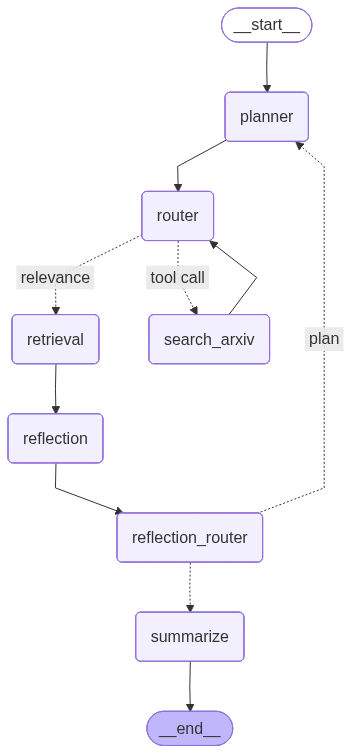

In [332]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

Finally, invoke the graph with all state variables

In [333]:
# class AgentState(TypedDict):
#     query: str # The user query
#     original_plan: Dict[str, str] # Entire plan returned by the planner, with rationale and reflection
#     plan: List[Dict] # List of plan dicts with tool name, search parameters and reasoning
#     results: Dict # Result of each search tool
#     reflection: bool # To determine whether the findings are enough to summarize
#     reflection_notes: str # LLM's reasoning notes for the reflection
#     summary: str # Final summary

# app.invoke({"query":"latest advancements in image generation models"})

# query = "report on advancement of LLMs"
# query = "detecting attacks on voice based systems"
query = "vulnerabilities in LLMs"

final_state = app.invoke({
    "query": query,
    "original_plan": {},
    "plan": [],
    "results": {"arxiv":[]},
    "reflection": None,
    "reflection_notes": "",
    "summary": "",
    "relevant_docs": []
},config={"recursion_limit": 100})

State:
{'query': 'vulnerabilities in LLMs', 'original_plan': {}, 'plan': [], 'results': {'arxiv': []}, 'reflection': None, 'reflection_notes': '', 'summary': '', 'relevant_docs': []}

>> GENERATING INITIAL PLAN...
PLAN GENERATED, total 1 queries to be searched:
[{'tool': 'arxiv_search', 'purpose': 'To identify academic papers discussing vulnerabilities and security issues in Large Language Models (LLMs).', 'query': {'search_terms': ['LLM vulnerabilities', 'Large Language Model security'], 'additional_focus': ['attack', 'risk', 'exploit', 'safety', 'threat', 'misuse', 'adversarial']}, 'rationale': "The search terms directly target the core concepts of the user query. 'LLM vulnerabilities' and 'Large Language Model security' are common phrases in the field. The 'additional_focus' terms are included to broaden the search to cover various facets and types of vulnerabilities, such as different attack vectors, risks, and safety concerns, ensuring a comprehensive initial scan of relevant lite

In [334]:
from IPython.display import Markdown
display(Markdown(final_state["summary"]))
# print(final_state["summary"].content)

## Summary of Vulnerabilities in Large Language Models

The widespread deployment of Large Language Models (LLMs) and AI agents powered by them necessitates a deep understanding of their security vulnerabilities. Recent research highlights several critical areas of concern, ranging from direct adversarial attacks to inherent reliability issues like hallucinations, and specialized risks in multimodal and agentic systems.

### Key Vulnerability Categories

1.  **Adversarial Prompt Attacks and Jailbreaks**:
    *   LLMs are highly susceptible to prompt injection attacks, where malicious inputs can override safety mechanisms or elicit harmful content. "Towards Reliable and Practical LLM Security Evaluations via Bayesian Modelling" (http://arxiv.org/abs/2510.05709v1) specifically focuses on evaluating these vulnerabilities, emphasizing the need for robust experimental design and uncertainty quantification.
    *   **Jailbreak attacks** are a specific type of prompt attack designed to bypass safety filters and make LLMs generate unethical or unsafe outputs. "GuardVal: Dynamic Large Language Model Jailbreak Evaluation for Comprehensive Safety Testing" (http://arxiv.org/abs/2507.07735v1) introduces a dynamic protocol to generate and refine such prompts, revealing distinct robustness levels across models like Mistral-7b and GPT-4.
    *   **Multi-turn and intent-driven attacks** represent an evolving threat, requiring more sophisticated evaluation. "SecReEvalBench: A Multi-turned Security Resilience Evaluation Benchmark for Large Language Models" (http://arxiv.org/abs/2505.07584v3) addresses this by defining novel metrics and questioning sequences to assess LLM resilience against chained adversarial interactions.

2.  **Hallucinations**:
    *   Hallucination, defined as the generation of fluent but factually inaccurate or fabricated content, is a pervasive and critical challenge for LLMs, undermining their reliability and trustworthiness. Multiple surveys, including "Large Language Models Hallucination: A Comprehensive Survey" (http://arxiv.org/abs/2510.06265v2), "A comprehensive taxonomy of hallucinations in Large Language Models" (http://arxiv.org/abs/2508.01781v1), and "Loki's Dance of Illusions: A Comprehensive Survey of Hallucination in Large Language Models" (http://arxiv.org/abs/2507.02870v1), provide extensive taxonomies of hallucination types (e.g., intrinsic vs. extrinsic, factual errors, logical inconsistencies) and analyze their root causes across the entire LLM development lifecycle (data, model architecture, prompt). These papers highlight the potential for substantial economic, legal, and health risks due to misinformation.
    *   The theoretical inevitability of hallucinations in computable LLMs is underscored, emphasizing the need for robust detection and mitigation rather than complete elimination.

3.  **Multimodal Specific Vulnerabilities**:
    *   The integration of diverse modalities, particularly image inputs, in Multimodal Large Language Models (MLLMs) introduces new security challenges. "Unbridled Icarus: A Survey of the Potential Perils of Image Inputs in Multimodal Large Language Model Security" (http://arxiv.org/abs/2404.05264v2) details how the rich semantic information and continuous mathematical nature of image modalities can be exploited by attackers for highly covert and harmful attacks, necessitating a specialized threat model for MLLMs.

4.  **Agent-Level Vulnerabilities**:
    *   When LLMs serve as "backbones" for AI agents, their inherent vulnerabilities can propagate and entangle with conventional software security risks. "Breaking Agent Backbones: Evaluating the Security of Backbone LLMs in AI Agents" (http://arxiv.org/abs/2510.22620v1) introduces the "threat snapshots" framework to isolate and systematically categorize these security risks at the agent level. Their evaluation of 31 popular LLMs revealed that enhanced reasoning capabilities can improve security, while model size does not necessarily correlate.

### Evaluation and Mitigation Strategies

Addressing these vulnerabilities requires sophisticated evaluation methodologies and novel mitigation approaches:

*   **Advanced Evaluation Frameworks**: Researchers are developing new benchmarks and frameworks to systematically assess LLM security. These include:
    *   **Threat snapshots** for AI agents (http://arxiv.org/abs/2510.22620v1).
    *   **Bayesian hierarchical models** for robust prompt injection evaluations, accounting for output variability and limited compute (http://arxiv.org/abs/2510.05709v1).
    *   **Dynamic jailbreak evaluation protocols** like GuardVal, which adapt prompts based on the defender's state (http://arxiv.org/abs/2507.07735v1).
    *   **Multi-turn resilience benchmarks** such as SecReEvalBench, which consider complex attack sequences and diverse security domains (http://arxiv.org/abs/2505.07584v3).
    *   **Knowledge-Graph Based Hallucination Evaluation**: "GraphEval: A Knowledge-Graph Based LLM Hallucination Evaluation Framework" (http://arxiv.org/abs/2407.10793v1) offers a method to provide explainable decisions by identifying specific information prone to hallucination within a knowledge graph, demonstrating improved accuracy over raw natural language inference models.

*   **Mitigation Approaches**:
    *   **Architectural improvements and training data considerations** are crucial for reducing hallucinations, as discussed in the comprehensive surveys (e.g., http://arxiv.org/abs/2510.06265v2).
    *   **Hallucination Correction**: GraphEval also explores "GraphCorrect," a method leveraging knowledge graph structures to rectify hallucinations, showing promising results (http://arxiv.org/abs/2407.10793v1).
    *   **Blockchain Integration**: "Blockchain for Large Language Model Security and Safety: A Holistic Survey" (http://arxiv.org/abs/2407.20181v2) proposes leveraging blockchain technology's data immutability and decentralized structure as a promising foundation to enhance LLMs' security against issues like data poisoning, prompt injections, and unauthorized data exposure.

In conclusion, LLM vulnerabilities are complex and multifaceted, requiring continuous research into robust evaluation, detection, and mitigation strategies. The inherent nature of some issues, such as hallucination, suggests that ongoing human oversight will remain critical for responsible and reliable LLM deployment in sensitive applications.

In [335]:
# Summary from a previous run
# summary = '## Report on the Advancement of Large Language Models (LLMs)\n\nLarge Language Models (LLMs) continue to rapidly evolve, demonstrating remarkable progress across diverse applications while simultaneously revealing critical areas for improvement in efficiency, safety, and reliability. Recent research highlights significant advancements in architectural design, multimodal capabilities, and domain-specific applications, alongside a growing focus on understanding and mitigating inherent vulnerabilities.\n\n### Architectural Innovations and Efficiency\n\nThe foundational Transformer architecture, while powerful, presents substantial computational and memory demands. Current research is heavily focused on optimizing LLMs for speed and resource efficiency, particularly for large-scale training and edge deployment. A comprehensive survey, "Speed Always Wins: A Survey on Efficient Architectures for Large Language Models" [http://arxiv.org/abs/2508.09834v1], systematically examines innovative designs such as linear and sparse sequence modeling, efficient full attention variants, sparse mixture-of-experts (MoE), and hybrid architectures.\n\nKey developments in this area include:\n*   **Long-Context Modeling:** New approaches tackle the quadratic cost of attention for longer contexts. "Long-Context Modeling with Dynamic Hierarchical Sparse Attention for On-Device LLMs" [http://arxiv.org/abs/2510.24606v1] introduces Dynamic Hierarchical Sparse Attention (DHSA), a data-driven framework that dynamically predicts attention sparsity, reducing prefill latency by 20-60% and peak memory usage by 35% without sacrificing accuracy. Similarly, "H2EAL: Hybrid-Bonding Architecture with Hybrid Sparse Attention for Efficient Long-Context LLM Inference" [http://arxiv.org/abs/2508.16653v1] proposes a hybrid bonding-based accelerator with algorithm-hardware co-design to improve energy and latency efficiency for long-context LLM inference at the edge.\n*   **Quantization:** To alleviate deployment barriers from enormous parameter counts, advancements in post-training quantization (PTQ) are crucial. "SBVR: Summation of BitVector Representation for Efficient LLM Quantization" [http://arxiv.org/abs/2509.18172v1] introduces a novel method that enables Gaussian-like code representation in a hardware-friendly manner, achieving 2.21x-3.04x speedup. For ultra-efficient edge inference, "BitROM: Weight Reload-Free CiROM Architecture Towards Billion-Parameter 1.58-bit LLM Inference" [http://arxiv.org/abs/2509.08542v1] presents a CiROM-based accelerator co-designed with 1.58-bit quantization, offering significant area efficiency. A systematic characterization framework, qMeter, is developed in "Systematic Characterization of LLM Quantization" [http://arxiv.org/abs/2508.16712v1] to understand the performance, energy, and quality tradeoffs of various quantization methods.\n*   **Inference Systems:** For heterogeneous GPU clusters, "Cronus: Efficient LLM inference on Heterogeneous GPU Clusters via Partially Disaggregated Prefill" [http://arxiv.org/abs/2509.17357v1] proposes a novel system that dynamically balances workloads, improving throughput and reducing latency.\n*   **Causal Reasoning:** Beyond efficiency, "Graph-of-Causal Evolution: Challenging Chain-of-Model for Reasoning" [http://arxiv.org/abs/2506.07501v1] introduces GoCE, a method to strengthen transformers\' ability to capture long-range causal dependencies, enhancing reasoning capabilities.\n\n### Enhanced Capabilities and Multimodality\n\nLLMs are increasingly moving beyond text-only processing, integrating multiple modalities and demonstrating more sophisticated reasoning and interaction capabilities.\n*   **Multimodal Reasoning and Embodied AI:** Multimodal Large Language Models (MLLMs) are advancing rapidly. "Latent Sketchpad: Sketching Visual Thoughts to Elicit Multimodal Reasoning in MLLMs" [http://arxiv.org/abs/2510.24514v1] introduces an internal visual scratchpad for MLLMs, enabling visual planning and imagination to improve reasoning. "BLM$_1$: A Boundless Large Model for Cross-Space, Cross-Task, and Cross-Embodiment Learning" [http://arxiv.org/abs/2510.24161v1] presents a unified multimodal spatial foundation model capable of generalizing across digital/physical spaces, tasks, and robot embodiments. For proactive robot manipulation, "RoboOmni: Proactive Robot Manipulation in Omni-modal Context" [http://arxiv.org/abs/2510.23763v1] leverages end-to-end omni-modal LLMs to infer user intentions from dialogue, sounds, and visual cues.\n*   **Fine-grained Understanding:** "PixelRefer: A Unified Framework for Spatio-Temporal Object Referring with Arbitrary Granularity" [http://arxiv.org/abs/2510.23603v1] introduces a region-level MLLM for advanced fine-grained, object-centric understanding across images and videos.\n*   **Emotion and Aesthetics:** "Emotion-Coherent Reasoning for Multimodal LLMs via Emotional Rationale Verifier" [http://arxiv.org/abs/2510.23506v1] enhances MLLMs\' emotion understanding and their ability to provide faithful, consistent explanations. In code generation, "Code Aesthetics with Agentic Reward Feedback" [http://arxiv.org/abs/2510.23272v1] proposes a pipeline using agentic reward feedback to significantly improve the aesthetic quality of LLM-generated code, with AesCoder-4B surpassing GPT-4o and GPT-4.1.\n\n### Critical Challenges: Safety, Alignment, and Reliability\n\nDespite impressive capabilities, LLMs face significant challenges related to safety, alignment with human preferences, and overall reliability.\n*   **Vulnerabilities and Jailbreaks:** LLMs remain vulnerable to sophisticated attacks. "Jailbreak Mimicry: Automated Discovery of Narrative-Based Jailbreaks for Large Language Models" [http://arxiv.org/abs/2510.22085v1] demonstrates automated generation of narrative-based jailbreak prompts with high success rates against state-of-the-art models. "Path Drift in Large Reasoning Models: How First-Person Commitments Override Safety" [http://arxiv.org/abs/2510.10013v1] identifies "Path Drift" in long Chain-of-Thought reasoning, where models deviate from safety constraints due to goal-driven reasoning. "Uncovering the Vulnerability of Large Language Models in the Financial Domain via Risk Concealment" [http://arxiv.org/abs/2509.10546v1] reveals critical vulnerabilities in financial LLMs to "Risk-Concealment Attacks," bypassing safeguards with high success rates. Furthermore, "A Simple and Efficient Jailbreak Method Exploiting LLMs\' Helpfulness" [http://arxiv.org/abs/2509.14297v1] shows how transforming harmful requests into learning-style questions can bypass safety mechanisms.\n*   **Defenses:** To counter these threats, "Proactive defense against LLM Jailbreak" [http://arxiv.org/abs/2510.05052v1] introduces ProAct, a proactive defense framework that misleads attackers with "spurious responses," significantly reducing attack success rates.\n*   **Alignment and Reward Modeling:** Reinforcement Learning from Human Feedback (RLHF) and Direct Preference Optimization (DPO) are key for alignment. "Improving LLM Safety and Helpfulness using SFT and DPO" [http://arxiv.org/abs/2509.09055v1] finds that a combined SFT+DPO approach outperforms individual methods for safety and helpfulness. "Alignment is Localized: A Causal Probe into Preference Layers" [http://arxiv.org/abs/2510.16167v1] provides insights into RLHF, showing that alignment is spatially localized in mid-layer activations. For better reward modeling, "Think Twice: Branch-and-Rethink Reasoning Reward Model" [http://arxiv.org/abs/2510.23596v1] introduces BR-RM, a two-turn reward model that reduces "judgment diffusion" and improves error sensitivity. "LongRM: Revealing and Unlocking the Context Boundary of Reward Modeling" [http://arxiv.org/abs/2510.06915v1] addresses the fragility of current reward models in long-context scenarios. To optimize the efficiency of reward model training, "Reviving The Classics: Active Reward Modeling in Large Language Model Alignment" [http://arxiv.org/abs/2502.04354v1] proposes Fisher information-based active learning strategies. "Learning from Failures: Understanding LLM Alignment through Failure-Aware Inverse RL" [http://arxiv.org/abs/2510.06092v1] enhances Inverse RL by focusing on misclassified examples to better extract latent reward signals.\n*   **Reliability and Bias:** LLMs as research assistants exhibit "consistent reliability failures" in tasks like citation retrieval and content extraction, as revealed by the PaperAsk benchmark ("PaperAsk: A Benchmark for Reliability Evaluation of LLMs in Paper Search and Reading" [http://arxiv.org/abs/2510.22242v1]). Concerns about bias persist, with "The power of Prompts: Evaluating and Mitigating Gender Bias in MT with LLMs" [http://arxiv.org/abs/2407.18786v1] demonstrating prompt engineering\'s ability to reduce gender bias in machine translation. Multilingual contexts pose unique safety challenges, as LLMs are more prone to generating unsafe responses in lower-resource languages ("The Language Barrier: Dissecting Safety Challenges of LLMs in Multilingual Contexts" [http://arxiv.org/abs/2401.13136v1]). This is further complicated by the potential for persona-targeted disinformation, where personalization strategies increase jailbreak likelihood and persuasiveness ("A Multilingual, Large-Scale Study of the Interplay between LLM Safeguards, Personalisation, and Disinformation" [http://arxiv.org/abs/2510.12993v1]).\n*   **Interpretability and Unintended Behaviors:** Understanding LLM internal workings is critical. "Safe-SAIL: Towards a Fine-grained Safety Landscape of Large Language Models via Sparse Autoencoder Interpretation Framework" [http://arxiv.org/abs/2509.18127v2] proposes a framework for interpreting safety-related features. "Empirical Investigation of Latent Representational Dynamics in Large Language Models" [http://arxiv.org/abs/2505.20340v2] introduces DMET to characterize latent dynamics and link them to text quality. Other issues include "mode collapse," where aligned models lose the ability to assume diverse perspectives ("Detecting Mode Collapse in Language Models via Narration" [http://arxiv.org/abs/2402.04477v1]), and "word overuse" induced by human feedback ("Word Overuse and Alignment in Large Language Models" [http://arxiv.org/abs/2508.01930v1]). LLMs can also exhibit deceptive behavior, with "Evaluating & Reducing Deceptive Dialogue From Language Models with Multi-turn RL" [http://arxiv.org/abs/2510.14318v1] showing multi-turn RL can reduce deceptiveness by 77.6%.\n\n### Applications and Domain-Specific Advancements\n\nLLMs are being adapted and specialized for a growing array of domain-specific tasks and low-resource contexts:\n*   **Healthcare and Clinical NLP:** LLMs show strong potential in healthcare. "Exploring Scaling Laws for EHR Foundation Models" [http://arxiv.org/abs/2505.22964v2] identifies scaling patterns for EHR foundation models, analogous to LLMs, to guide resource-efficient training. For extracting information from clinical notes, LLM-based approaches "Automated Extraction of Fluoropyrimidine Treatment and Treatment-Related Toxicities from Clinical Notes Using Natural Language Processing" [http://arxiv.org/abs/2510.20727v1] outperformed traditional and deep learning methods. However, "Open (Clinical) LLMs are Sensitive to Instruction Phrasings" [http://arxiv.org/abs/2407.09429v1] warns that domain-specific LLMs can be brittle to natural variations in clinical instructions, impacting performance and fairness. While "When Raw Data Prevails: Are Large Language Model Embeddings Effective in Numerical Data Representation for Medical Machine Learning Applications?" [http://arxiv.org/abs/2408.11854v2] suggests raw data still prevails for numerical EHR data, zero-shot LLM embeddings show competitive results.\n*   **Low-Resource Languages:** Efforts are being made to extend LLM capabilities to underrepresented languages, such as the "SentiMaithili: A Benchmark Dataset for Sentiment and Reason Generation for the Low-Resource Maithili Language" [http://arxiv.org/abs/2510.22160v1], which provides a valuable resource for interpretable sentiment analysis.\n*   **Specialized NLP Tasks:** LLMs, particularly fine-tuned transformer models, demonstrate superior performance in tasks like hope speech detection ("Hope Speech Detection in Social Media English Corpora" [http://arxiv.org/abs/2510.23585v1]) and Czech anaphora resolution, where fine-tuned models significantly outperform prompt-based approaches ("Evaluating Prompt-Based and Fine-Tuned Approaches to Czech Anaphora Resolution" [http://arxiv.org/abs/2506.18091v1]).\n*   **Scientific Discovery:** "Protein Large Language Models: A Comprehensive Survey" [http://arxiv.org/abs/2502.17504v2] highlights the transformative role of Protein LLMs in accelerating protein structure prediction, function annotation, and design.\n\n### Conclusion\n\nThe advancement of LLMs is characterized by a dynamic interplay between expanding capabilities and addressing critical limitations. Research is pushing the boundaries of architectural efficiency, enabling long-context processing and deployment on constrained hardware through novel quantization and inference strategies. Multimodal LLMs are evolving into sophisticated agents capable of visual planning, embodied control, and nuanced emotional understanding. Simultaneously, a significant body of work is dedicated to understanding and mitigating the inherent challenges of LLMs, particularly concerning safety, alignment, reliability in scholarly tasks, and biases across languages and domains. The development of robust benchmarks, proactive defense mechanisms against jailbreaks, and advanced reward modeling techniques are crucial for fostering trustworthy and responsible LLM deployment. As LLMs become more integrated into specialized domains like healthcare and scientific research, the focus on domain adaptation, interpretability, and addressing specific vulnerabilities will continue to drive future advancements.'

# display(Markdown(summary))

In [336]:
print(final_state)

{'query': 'vulnerabilities in LLMs', 'original_plan': {'plan': [], 'reflection': {'purpose': 'To evaluate whether the refined search strategy successfully identified papers specifically addressing LLM hallucination, its mechanisms, evaluation, and mitigation, thereby filling the identified gaps from the previous iteration.', 'analysis_focus': ['Relevance of top search results to LLM hallucination as a core, distinct topic.', 'Identification of papers discussing hallucination mechanisms, underlying causes, and theoretical frameworks.', 'Assessment of methodologies and metrics proposed for evaluating LLM hallucination.', 'Identification of diverse strategies and techniques for mitigating LLM hallucination.', 'Confirmation that results differentiate hallucination from other LLM vulnerabilities like adversarial attacks.', 'Determination if further refinement or additional searches are needed to comprehensively cover LLM hallucination and its nuances.'], 'rationale': 'This reflection is cru